<a href="https://colab.research.google.com/github/ass77/hybridCoeLTSM/blob/main/xLTSM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Enter a stock ticker: amzn


Epoch 1/10
1953/1953 [==============================] - 46s 22ms/step - loss: 0.0013 - accuracy: 0.0000e+00
Epoch 2/10
1953/1953 [==============================] - 43s 22ms/step - loss: 2.3307e-04 - accuracy: 0.0000e+00
Epoch 3/10
1953/1953 [==============================] - 43s 22ms/step - loss: 2.1068e-04 - accuracy: 0.0000e+00
Epoch 4/10
1953/1953 [==============================] - 43s 22ms/step - loss: 1.4288e-04 - accuracy: 0.0000e+00
Epoch 5/10
1953/1953 [==============================] - 42s 22ms/step - loss: 9.5223e-05 - accuracy: 0.0000e+00
Epoch 6/10
1953/1953 [==============================] - 42s 22ms/step - loss: 9.4799e-05 - accuracy: 0.0000e+00
Epoch 7/10
1953/1953 [==============================] - 43s 22ms/step - loss: 1.0268e-04 - accuracy: 0.0000e+00
Epoch 8/10
1953/1953 [==============================] - 43s 22ms/step - loss: 1.1758e-04 - accuracy: 0.0000e+00
Epoch 9/10
1953/1953 [==============================] - 43s 22ms/step - loss: 8

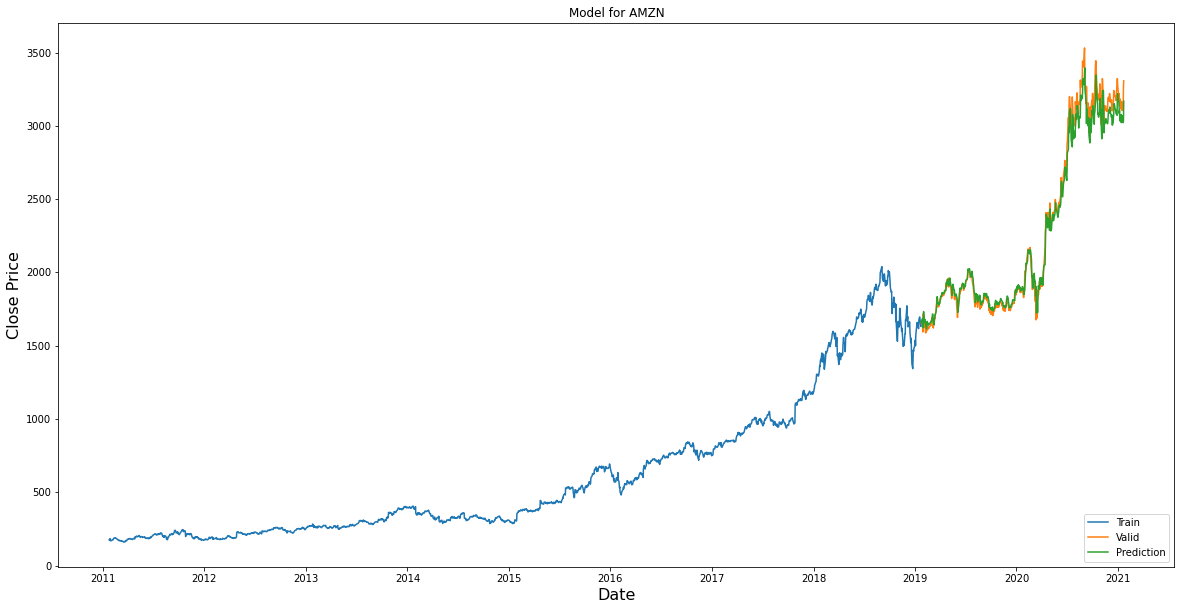

                  Close  Predictions
Date                                
2019-01-24  1654.930054  1655.536743
2019-01-25  1670.569946  1667.724609
2019-01-28  1637.890015  1684.902710
2019-01-29  1593.880005  1662.435791
2019-01-30  1670.430054  1623.212891
...                 ...          ...
2021-01-14  3127.469971  3071.218750
2021-01-15  3104.250000  3043.413330
2021-01-19  3120.760010  3021.345703
2021-01-20  3263.379883  3034.602783
2021-01-21  3306.989990  3168.039795

[503 rows x 2 columns]
The accuracy of the LSTM Model predicting the movement of a stock each day is 48.6%
     Valid Movement  Predicted Movement
0                 0                   0
1                 1                   0
2                 1                   1
3                 0                   1
4                 0                   0
..              ...                 ...
497               1                   0
498               1                   1
499               0                   1
500        

In [1]:
#import the libraries
import math
import warnings
import datetime 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from pandas_datareader import DataReader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Dense, LSTM

warnings.filterwarnings("ignore")

#get the stock quote for the past 10 years
stock = input("Enter a stock ticker: ")
num_of_years = 10
start_date = datetime.datetime.now() - datetime.timedelta(days=int(365.25*num_of_years))
end_date = datetime.date.today()


df = DataReader(stock, "yahoo", start_date, end_date)
data = df.filter(['Close'])
dataset = data.values
train_data_len = math.ceil(len(dataset)*.8)

#scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

#create the training dataset
train_data = scaled_data[0:train_data_len, :]

#split the data into x_train and y_train dataset
x_train=[]
y_train=[]

for i in range(60,len(train_data)):
  x_train.append(train_data[i-60:i, 0])
  y_train.append(train_data[i, 0])
  if i<=61:
    #print(x_train)
    #print(y_train)
    print()

#convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

#reshape the data to 3 dimension
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


#build LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(50,return_sequences=False))

model.add(Dense(25))
model.add(Dense(1))

#compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

#train the model
model.fit(x_train, y_train, batch_size=1, epochs=10)

#create test dataset
test_data = scaled_data[train_data_len-60:, :]

#create dataset x_test, y_test
x_test = []
y_test = dataset[train_data_len:, :]
for i in range(60,len(test_data)):
  x_test.append(test_data[i-60:i, 0])

#convert data to numpy array
x_test = np.array(x_test)

#reshape the data 3d?
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

#get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)



#get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean((predictions-y_test)**2))

#plot the data
train = data[:train_data_len]
valid = data[train_data_len:]
valid['Predictions'] = predictions
plt.figure(figsize=(20,10))
plt.title('Model for {}'.format(stock.upper()))
plt.xlabel('Date', fontsize=16)
plt.ylabel('Close Price', fontsize=16)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Train','Valid','Prediction'],loc='lower right')
plt.show()

print (valid)

# find the accuracy based on predicting day-to-day movements 
valid_movement = []
pred_movement = []
close_prices = valid.Close.tolist()
pred_prices = valid.Predictions.tolist()
        
n = 0

for index, value in enumerate(close_prices[:-1]):
    if value > close_prices[index+1]: 
        valid_movement.append(1)
    else:
        valid_movement.append(0)

for index, value in enumerate(pred_prices[:-1]):
    if value > pred_prices[index+1]: 
        pred_movement.append(1)
    else:
        pred_movement.append(0)

for val, pred in zip(valid_movement, pred_movement):
    if val == pred:
        n=n+1
    else:
        pass

total = len(valid_movement)
accuracy = n/total
print (f'The accuracy of the LSTM Model predicting the movement of a stock each day is {100 * round(accuracy, 3)}%')

dataframe = pd.DataFrame(list(zip(valid_movement, pred_movement)), columns =['Valid Movement', 'Predicted Movement'])
print (dataframe)

#get predicted price for next day
last_60day = data[-60:].values
last_60day_scaled = scaler.transform(last_60day)
xx_test = []
xx_test.append(last_60day_scaled)
xx_test = np.array(xx_test)
xx_test = np.reshape(xx_test, (xx_test.shape[0], xx_test.shape[1],1))
pred = model.predict(xx_test)
pred = scaler.inverse_transform(pred)
pred = pred[0]
pred = pred[0]
print("The predicted price for the next trading day is: {}".format(round(pred, 2)))

#get stats
#Root mean squared error 
print (f'The root mean squared error is {round(rmse, 2)}')

error = mean_squared_error(valid['Close'].tolist(), valid['Predictions'].tolist())
print('Testing Mean Squared Error: %.3f' % error)

